# Keypoint Transfer

In this notebook, we test the keypoint transfer by argmax matching to the features of another image.

In [35]:

from src.logging.visualization import Demo
import torch
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configuration File Loading

The configuration file `configs/demo_keypoint_transfer`should specify the dataset and featurizer. In order to test multiple configurations, you can change the file accordingly.

In [36]:
from hydra import compose, initialize
with initialize(config_path="./configs", job_name="test_app"):
    args = compose(config_name="demo_keypoint_transfer")


### Dataset Loading

First, we will load the datasat specified in the configutation file. The supervision mode determines whether augmentations are used.

In [37]:
from src.dataset.spair import SpairDataset2
from src.dataset.cub_200_pairs import CUBPairDataset
from src.dataset.pfpascal_pairs import PFPascalPairs
from src.dataset.apk_pairs import AP10KPairs
if args.dataset.name == 'spair':
    dataset = SpairDataset2(args.dataset, split='test')
elif args.dataset.name == 'cub':
    dataset = CUBPairDataset(args.dataset, split='test')
elif args.dataset.name == 'pfpascal':
    dataset = PFPascalPairs(args.dataset, split='test')
elif args.dataset.name == 'ap10k':
    dataset = AP10KPairs(args.dataset, split='test')

else:
    raise ValueError(f"Dataset {args.dataset.name} does not provide annotation for training")
print(f"Dataset: {args.dataset}")
print(f"Supervision: {args.dataset.sup}")

Dataset: {'name': 'ap10k', 'dataset_path': '<your_dataset_path>/ap-10k', 'save_path': '<your_precomputed_features_path>', 'save_path_masks': '<your_precomputed_masks_path>', 'hydra': {'output_subdir': None}, 'sup': 'sup_original', 'flip_aug': True, 'cat': 'all', 'subsample': None}
Supervision: sup_original


### Category Selection

The category can be changed according to the dataset at hand.

In [38]:
print(dataset.all_cats)
# We choose the first category
cat = "bobcat"
dataset.init_kps_cat(cat)
print(f"Category: {cat}")

['alouatta', 'antelope', 'argali sheep', 'beaver', 'bison', 'black bear', 'bobcat', 'brown bear', 'buffalo', 'cat', 'cheetah', 'chimpanzee', 'cow', 'deer', 'dog', 'elephant', 'fox', 'giraffe', 'gorilla', 'hamster', 'hippo', 'horse', 'jaguar', 'king cheetah', 'leopard', 'lion', 'marmot', 'monkey', 'moose', 'mouse', 'noisy night monkey', 'otter', 'panda', 'panther', 'pig', 'polar bear', 'rabbit', 'raccoon', 'rat', 'rhino', 'sheep', 'skunk', 'snow leopard', 'spider monkey', 'squirrel', 'tiger', 'uakari', 'weasel', 'wolf', 'zebra']
Category: bobcat


### Featurizer Initialization
Load the featurizer specified in the configuation file.

In [39]:
from src.models.featurizer.utils import get_featurizer_name, get_featurizer

preprocessed = False # True if we want to use preprocessed features, which are already stored to disk
if preprocessed:
    featurizer_name = get_featurizer_name(args.featurizer)
    dataset.featurizer_name = featurizer_name
else:
    print(f"Memory allocated before loading: {torch.cuda.memory_allocated()//1024**2} MB")
    if args.featurizer.model == 'dift_sd':
        args.featurizer.all_cats = dataset.all_cats
    featurizer = get_featurizer(args.featurizer)
    dataset.featurizer = featurizer
    dataset.featurizer_kwargs = args.featurizer
    dataset.featurizer_name = featurizer.name
    print(f"Memory allocated after loading: {torch.cuda.memory_allocated()//1024**2} MB")
print(f"Featurizer: {dataset.featurizer_name}")

Memory allocated before loading: 2813 MB


Using cache found in /dev/shm/hreg/cache/torch/hub/facebookresearch_dinov2_main


Memory allocated after loading: 3132 MB
Featurizer: geco


### Feature Refiner Initialization
In case of loading some basline architecture, we have to process the feature output of the foundation model to obtain the final features.

In [40]:
from src.models.featurizer_refine import get_model_refine
if 'feat_refine' in args:
    print(f"Memory allocated: {torch.cuda.memory_allocated()//1024**3} GB")
    model_refine = get_model_refine(args.feat_refine)
    model_refine = model_refine.eval().to(device)
    print(f"Memory allocated: {torch.cuda.memory_allocated()//1024**3} GB")
else:
    model_refine = None

## Visualize Keypoint Transfer

We test the keypoint transfer interactively. After marking a query location in the source image, we can observe the correspondence in the target image. 

In [41]:

idx = 0
def init_demo(dataset, idx):
    dataset.return_imgs = True
    data = dataset[idx]
    imgs = [data['src_img'], data['trg_img']]
    ft = [data['src_ft'][None], data['trg_ft'][None]]
    if model_refine is not None:
        ft_new = [model_refine(ft[0].to(device)), model_refine(ft[1].to(device))]
    else:
        ft_new = [ft[0], ft[1]]
    img_size = [data['src_imsize'], data['trg_imsize']]
    demo = Demo(imgs, ft_new, img_size)
    return demo, data
demo, data = init_demo(dataset, idx)

In [42]:
# %matplotlib inline
# # get kp
# kp = data['src_kps']
# kp = kp[0]

# demo.plot_img_pairs(kp)

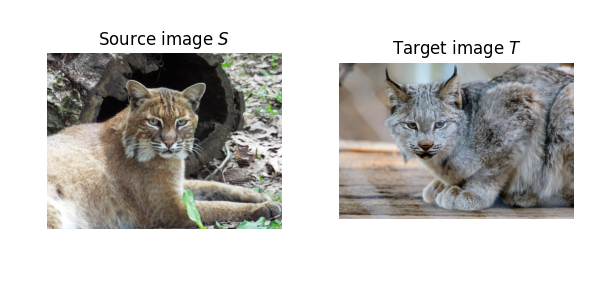

In [43]:
%matplotlib widget
if args.featurizer.model == 'sd15ema_dinov2':
    demo.plot_img_pairs_click(upsample=False)
else:
    demo.plot_img_pairs_click(upsample=True)
